In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
def CVaR(returns, alpha):
    var = np.sort(returns[:])[int(len(returns[:]) * alpha)]
    idx = np.where(returns[:] <= var)
    CVaR = np.mean(returns[idx])
    return CVaR

def CVaRplot(ax, ret, label, n =20):
    mean = mv(np.mean(ret, axis=0), n)
    xaxis = np.arange(0, mean.shape[0]*50, 50)
    std = mv(np.std(ret, axis=0), n)
    plt.plot(xaxis, mean, label=label, linewidth=2)
    plt.fill_between(xaxis, mean-0.5*std, mean+0.5*std, alpha=0.4)

def mv(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [2]:
def read(name, rang, alpha=0.25, reshape=1):
    file = np.load(name%(0))
    
    cvar = np.zeros(file.shape[0])
    for i in range(file.shape[0]):
        var = np.sort(file[i, :])[int(len(file[i, :]) * alpha)]
        idx = np.where(file[i, :] <= var)
        cvar[i] = np.mean(file[i, idx])
    cvar = np.expand_dims(cvar, axis = 0)
    
    for i in range(1, rang):
        file = np.load(name%(i))
        #file = file.reshape((-1, file.shape[1]*reshape))
        temp = np.zeros(file.shape[0])
        for i in range(file.shape[0]):
            var = np.sort(file[i, :])[int(len(file[i, :]) * alpha)]
            idx = np.where(file[i, :] <= var)
            temp[i] = np.mean(file[i, idx])
        temp = np.expand_dims(temp, axis = 0)
        cvar = np.concatenate([cvar, temp], axis = 0)
    return cvar

In [3]:
o = read('mrp_res/random_results_online_%d.npy', 1, alpha=0.25)

In [4]:
evalg = {}
onlineg = {}
for i in range(1, 9):
    e = read('mrp_res/e_greedy_%d'%(i)+'_results_eval_%d.npy', 9, alpha=0.25)
    o = read('mrp_res/e_greedy_%d'%(i)+'_results_online_%d.npy', 9, alpha=0.25)
    evalg[i] = e
    onlineg[i] = o

In [76]:
onlineo = {}
for i in [105, 10, 11, 6, 7, 85, 8, 95, 9]:
    e = read('mrp_res/opt_mrp_c_%d'%(i)+'_results_online_%d.npy', 9, alpha=0.25)
    onlineo[i] = e

In [62]:
onlineo2 = {}
for i in [15, 17, 20]:
    e = read('Mrpres/opt_mrp_c_%d'%(i)+'_trail_%d_episode_49000.p', 9, alpha=0.25)
    onlineo2[i] = e

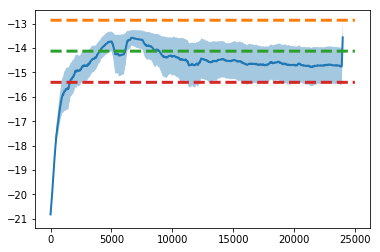

In [85]:
fig = plt.figure()
CVaRplot(fig, ss, label='Optimism C=10', n=50)
plt.plot(np.arange(25000), np.ones(25000) * -12.861797450359479, '--', linewidth=3)
plt.plot(np.arange(25000), np.ones(25000) * -14.128583926728682, '--', linewidth=3)
plt.plot(np.arange(25000), np.ones(25000) * -15.406251169207456, '--', linewidth=3)

Text(0,0.5,'CVaR')

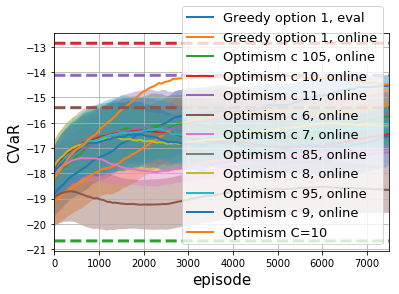

In [80]:
fig = plt.figure()
n = 50

for i in range(1, 2):
    CVaRplot(fig, evalg[i], label='Greedy option %d, eval'%(i), n=n)
    CVaRplot(fig, onlineg[i], label='Greedy option %d, online'%(i), n=n)

for i in onlineo.keys():
    CVaRplot(fig, onlineo[i], label='Optimism c %d, online'%(i), n=n)
CVaRplot(fig, o, label='Optimism C=10', n=n)

tot = 7500
plt.plot(np.arange(tot), np.ones(tot) * -20.66888775365751, '--', linewidth=3)
plt.plot(np.arange(tot), np.ones(tot) * -12.861797450359479, '--', linewidth=3)
plt.plot(np.arange(tot), np.ones(tot) * -14.128583926728682, '--', linewidth=3)
plt.plot(np.arange(tot), np.ones(tot) * -15.406251169207456, '--', linewidth=3)


plt.legend(loc=4, fontsize= 13)
plt.grid()
plt.xlim([0, 7500])
plt.xlabel('episode', fontsize=15)
plt.ylabel('CVaR', fontsize=15)

Text(0,0.5,'CVaR')

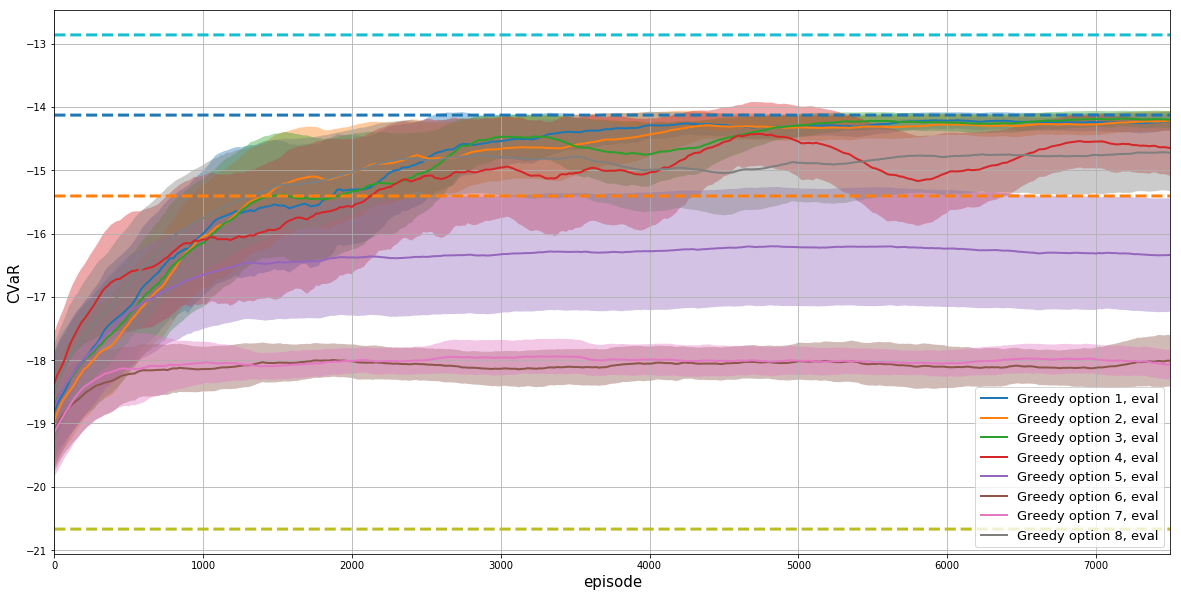

In [73]:
fig = plt.figure(figsize=(20, 10))
n = 50

for i in range(1, 9):
    CVaRplot(fig, evalg[i], label='Greedy option %d, eval'%(i), n=n)
    #CVaRplot(fig, onlineg[i], label='Greedy option %d, online'%(i), n=n)

tot = 7500
plt.plot(np.arange(tot), np.ones(tot) * -20.66888775365751, '--', linewidth=3)
plt.plot(np.arange(tot), np.ones(tot) * -12.861797450359479, '--', linewidth=3)
plt.plot(np.arange(tot), np.ones(tot) * -14.128583926728682, '--', linewidth=3)
plt.plot(np.arange(tot), np.ones(tot) * -15.406251169207456, '--', linewidth=3)


plt.legend(loc=4, fontsize= 13)
plt.grid()
plt.xlim([0, 7500])
plt.xlabel('episode', fontsize=15)
plt.ylabel('CVaR', fontsize=15)

## Terrain

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from terrain import Nav2D
%matplotlib inline

def CVaR_policy(p, x, alpha, N=20, Vmax=50, Vmin=-50, nAtoms=51, nA=4):
    dz = (Vmax - Vmin)/(nAtoms-1)
    Z = np.arange(nAtoms) * dz + Vmin
    Q = np.zeros(nA)
    for a in range(nA):
        values = np.zeros(N)
        for n in range(N):
            tau = np.random.uniform(0, alpha)
            idx = np.argmax((np.cumsum(p[x, a, :]) > tau) * 1.0)
            z = Z[idx]
            values[n] = z
        Q[a] = np.mean(values)
    return Q

def read(name):
    p = np.load(name)
    return p

def calc_CVaR(returns, alpha):
    var = np.sort(returns[:])[int(len(returns[:]) * alpha)]
    idx = np.where(returns[:] <= var)
    CVaR = np.mean(returns[idx])
    return CVaR

def CVaR(p, wolrd, alpha, N=100, gamma=0.95):
    returns = np.zeros(N)
    for ep in range(N):
        o = world.reset()
        terminal = False
        ret = []
        while not terminal:
            a = np.argmax(CVaR_policy(p, o, alpha=alpha, nA = world.nA))
            no, r, terminal = world.step(a)
            ret.append(r)
            o = no
        tot_ret = 0
        for r in reversed(ret):
            tot_ret = r + gamma*tot_ret
        returns[ep] = tot_ret
    return calc_CVaR(returns, alpha)

def path(p, world, alpha):
    o = world.reset()
    path = []
    terminal = False
    path.append(world.current_state)
    step = 0
    while not terminal and step < 1000:
        a = np.argmax(CVaR_policy(p, o, alpha=alpha, nA = world.nA))
        no, r, terminal = world.step(a)
        path.append(world.current_state)
        o = no
        step += 1
    return path

def draw(name, world, alpha):
    file = pickle.load(open(name, 'rb'))
    p = file['p']
    traj = path(p, world, alpha)
    matrix = world.obstacles
    matrix[world.goal_state] = -1
    matrix[world.initial_state] = 2
    for x, y in traj:
        plt.plot(x, y, '.', color = 'blue', markersize=5)
    plt.imshow(matrix.T)
    plt.title('CVaR at alpha=%g = %g'%(alpha, CVaR(p, world, alpha=alpha, N=20, gamma=0.95)))
    plt.show()

In [4]:
world = Nav2D(random=False)

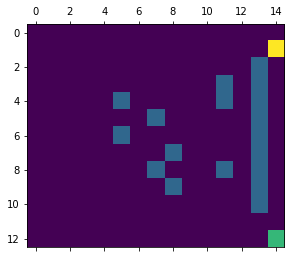

In [5]:
world._render()

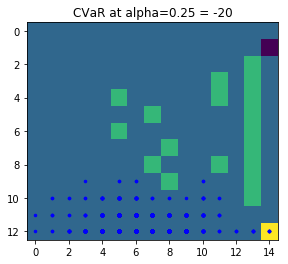

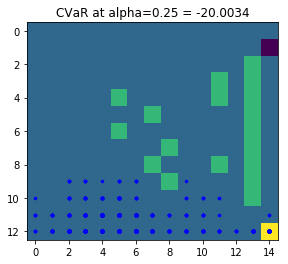

In [87]:
for i in [0, 1]:
    name = 'Navres/opt_c_50_trail_%d_episode_99000.p'%(i)
    draw(name, world, 0.25)

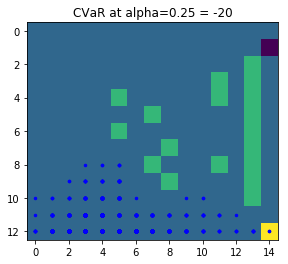

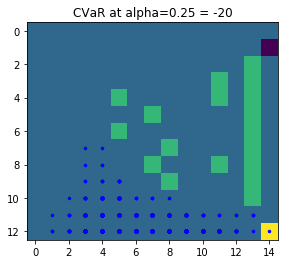

In [88]:
for i in [0, 1]:
    name = 'Navres/opt_c_45_trail_%d_episode_99000.p'%(i)
    draw(name, world, 0.25)

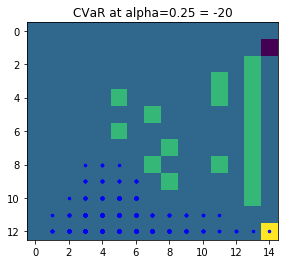

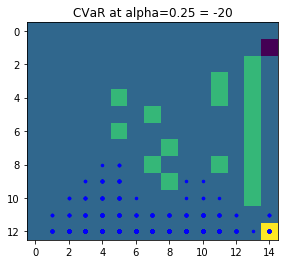

In [89]:
for i in [0, 1]:
    name = 'Navres/opt_c_40_trail_%d_episode_99000.p'%(i)
    draw(name, world, 0.25)

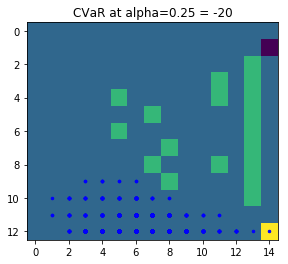

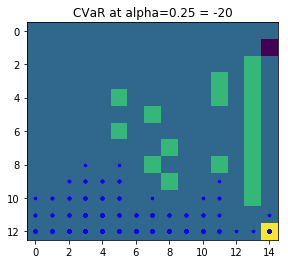

In [90]:
for i in [0, 1]:
    name = 'Navres/opt_c_35_trail_%d_episode_99000.p'%(i)
    draw(name, world, 0.25)

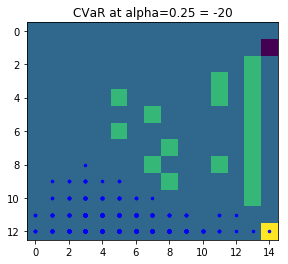

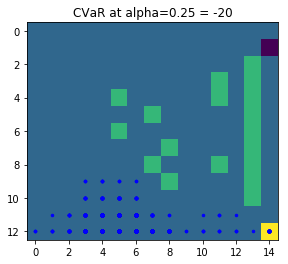

In [132]:
for i in [0, 1]:
    name = 'Navres/opt_c_30_trail_%d_episode_99000.p'%(i)
    draw(name, world, 0.25)

KeyboardInterrupt: 

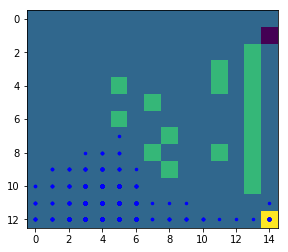

In [133]:
for i in [0, 1]:
    name = 'Navres/opt_c_25_trail_%d_episode_99000.p'%(i)
    draw(name, world, 0.25)

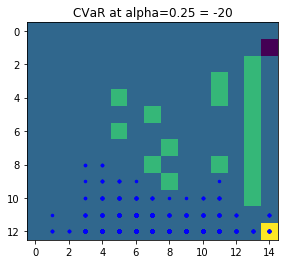

In [40]:
name = 'Navres/e_greedy_1_eval_version_1_episode_48000.p'
draw(name, world, 0.25)

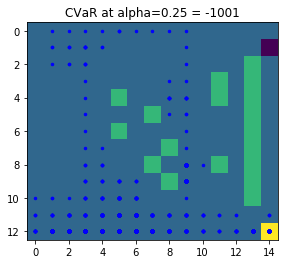

In [35]:
name = 'Navres/e_greedy_5_eval_version_1_episode_49000.p'
draw(name, world, 0.25)

In [41]:
#o = read('Navres/e_greedy_1_results_online_%d.npy', 1, alpha=0.25)
e = read('Navres/opt_mrp_c_5_results_online_%d.npy', 4, alpha=0.25)

In [56]:
onlineo = {}
for i in [2, 10, 5, 8]:
    e = read('Navres/opt_mrp_c_%d'%(i) + '_results_online_%d.npy', 5, alpha=0.25)
    onlineo[i] = e

Text(0,0.5,'CVaR')

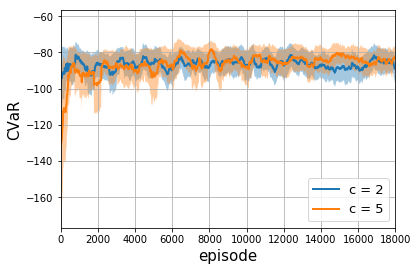

In [57]:
fig = plt.figure(); n=20
for i in [2, 5]:
    CVaRplot(fig, onlineo[i], label='c = %d'%(i), n=n)
plt.xlim([0, 18000])

plt.legend(loc=4, fontsize= 13)
plt.grid()
plt.xlabel('episode', fontsize=15)
plt.ylabel('CVaR', fontsize=15)

(-26, -18)

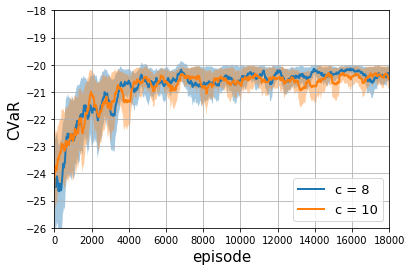

In [58]:
fig = plt.figure(); n=20
for i in [8, 10]:
    CVaRplot(fig, onlineo[i], label='c = %d'%(i), n=n)
plt.xlim([0, 18000])

plt.legend(loc=4, fontsize= 13)
plt.grid()
plt.xlabel('episode', fontsize=15)
plt.ylabel('CVaR', fontsize=15)
plt.ylim([-26, -18])

In [59]:
evalg = {}
onlineg = {}
for i in [1, 5]:
    e = read('Navres/e_greedy_%d'%(i)+'_results_eval_%d.npy', 2, alpha=0.25)
    o = read('Navres/e_greedy_%d'%(i)+'_results_online_%d.npy', 2, alpha=0.25)
    evalg[i] = e
    onlineg[i] = o

(0, 18000)

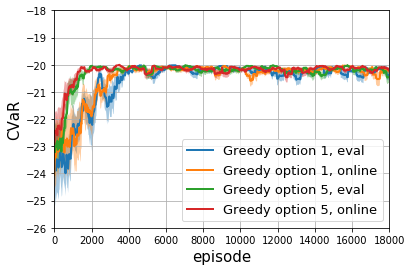

In [60]:
fig = plt.figure(); n=20
for i in [1, 5]:
    CVaRplot(fig, evalg[i], label='Greedy option %d, eval'%(i), n=n)
    CVaRplot(fig, onlineg[i], label='Greedy option %d, online'%(i), n=n)
plt.legend(loc=4, fontsize= 13)
plt.grid()
plt.xlabel('episode', fontsize=15)
plt.ylabel('CVaR', fontsize=15)
plt.ylim([-26, -18])
plt.xlim([0, 18000])

(0, 18000)

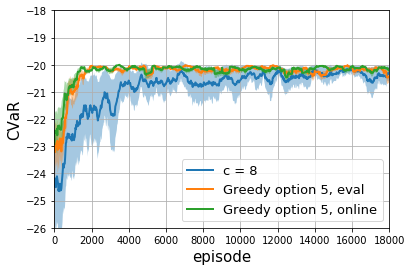

In [62]:
fig = plt.figure(); n=20
CVaRplot(fig, onlineo[8], label='c = 8', n=n)
CVaRplot(fig, evalg[5], label='Greedy option %d, eval'%(i), n=n)
CVaRplot(fig, onlineg[5], label='Greedy option %d, online'%(i), n=n)
plt.legend(loc=4, fontsize= 13)
plt.grid()
plt.xlabel('episode', fontsize=15)
plt.ylabel('CVaR', fontsize=15)
plt.ylim([-26, -18])
plt.xlim([0, 18000])

## New Saving Scheme

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from terrain import Nav2D
%matplotlib inline

In [7]:
def read(name, rang, alpha=0.25, reshape=1):
    file = pickle.load(open(name%(0), 'rb'))
    file = file['returns']
    
    cvar = np.zeros(file.shape[0])
    for i in range(file.shape[0]):
        var = np.sort(file[i, :])[int(len(file[i, :]) * alpha)]
        idx = np.where(file[i, :] <= var)
        cvar[i] = np.mean(file[i, idx])
    cvar = np.expand_dims(cvar, axis = 0)
    
    for i in range(1, rang):
        file = pickle.load(open(name%(i), 'rb'))
        file = file['returns']
        temp = np.zeros(file.shape[0])
        for i in range(file.shape[0]):
            var = np.sort(file[i, :])[int(len(file[i, :]) * alpha)]
            idx = np.where(file[i, :] <= var)
            temp[i] = np.mean(file[i, idx])
        temp = np.expand_dims(temp, axis = 0)
        cvar = np.concatenate([cvar, temp], axis = 0)
    return cvar

In [50]:
onlineo = {}
for i in [45, 40, 35, 30, 25, 20]:
    e = read('Navres/opt_c_%d'%(i)+'_trail_%d_episode_99000.p', 2, alpha=0.25)
    onlineo[i] = e
# for i in [5, 15]:
#     e = read('Navres/opt_c_%d'%(i)+'_trail_%d_episode_990000.p', 1, alpha=0.25)
#     onlineo[i] = e

EOFError: Ran out of input

In [192]:
onlineog = {}
for i in [1, 5]:
    e = read('Navres/e_greedy_%d'%(i)+'_eval_version_%d_episode_49700.p', 3, alpha=0.25)
    onlineog[i] = e

FileNotFoundError: [Errno 2] No such file or directory: 'Navres/e_greedy_1_eval_version_0_episode_49700.p'

In [44]:
fig = plt.figure(figsize=(12, 5)); n=10
for i in [50, 45, 40, 35, 30, 25, 20]:
    CVaRplot(fig, onlineo[i], label='Optimisin c= %d, online'%(i), n=n)
# for i in [1, 5]:
#     CVaRplot(fig, onlineog[i], label='e greedy option %d'%(i), n=n)
plt.legend(loc=4, fontsize= 13)
plt.grid()
plt.xlabel('episode', fontsize=15)
plt.ylabel('CVaR', fontsize=15)
plt.ylim([-40, -15]);
#plt.xlim([-100, 28000]);

KeyError: 50

<Figure size 864x360 with 0 Axes>

## FIX V_{min} V_{max} gamma

In [223]:
Vmin = -60; Vmax=10; gamma = 0.95
opt = 1; c = 0.1; trial = 5; n=80
name = '../results/Nav2DSmall/opt_%d_trail_%d_episode_89800.p'

In [196]:
def CVaR_policy(p, x, alpha, N=20, Vmax=60, Vmin=-50, nAtoms=51, nA=4):
    dz = (Vmax - Vmin)/(nAtoms-1)
    Z = np.arange(nAtoms) * dz + Vmin
    Q = np.zeros(nA)
    for a in range(nA):
        values = np.zeros(N)
        for n in range(N):
            tau = np.random.uniform(0, alpha)
            idx = np.argmax((np.cumsum(p[x, a, :]) > tau) * 1.0)
            z = Z[idx]
            values[n] = z
        Q[a] = np.mean(values)
    return Q
def CVaRopt(p, count, x, alpha, c=0.1, N=20,Vmax=60, Vmin=-50, nAtoms=51, nA=4):
    dz = (Vmax - Vmin)/(nAtoms-1)
    Z = np.arange(nAtoms) * dz + Vmin
    Q = np.zeros(nA)
    values = np.zeros(N)
    for a in range(nA):
        # Apply Optimism
        cdf = np.cumsum(p[x, a, :]) - c/np.sqrt(count[x, a])
        cdf = np.clip(cdf, a_min=0, a_max=None)
        cdf[-1] = 1 #Match the last one to 1
        cdf = np.tile(cdf, N).reshape(N, nAtoms)
        tau = np.random.uniform(0, alpha, N).reshape(N, 1)
        idx = np.argmax((cdf > tau) * 1.0, axis=1)
        # Average
        values = Z[idx]
        Q[a] = np.mean(values)
    return Q

def path(p, world, alpha):
    o = world.reset()
    path = []
    terminal = False
    path.append(world.current_state)
    x, y = world.current_state
    step = 0
    while not terminal and step < 50:
        v = CVaRopt(p['p'], p['counts'], x * world.maxY + y, alpha, c=opt)
        a= np.random.choice(np.flatnonzero(v == v.max()))
        no, r, terminal = world.step(a)
        path.append(world.current_state)
        o = no
        x, y = world.current_state
        step += 1
    return path

def draw(name, world, alpha, opt, trial, episodes):
    COLOR = ['blue', 'red', 'green', 'white']
    matrix = world.obstacles
    matrix[world.goal_state] = -1
    matrix[world.initial_state] = 2
    plt.imshow(matrix.T)
    i = 0
    for episode in episodes:
        file = pickle.load(open(name%(opt, trial, episode), 'rb'))
        traj = path(file, world, alpha)
        for x, y in traj:
            plt.plot(x, y, 'o', color = COLOR[i], markersize=(i + 1) * 2)
        plt.plot(x, y, 'o', color = COLOR[i], markersize=(i + 1) * 2, label = 'ep = %d'%(episode))
        i += 1
    plt.legend()
    return None

In [224]:
def newRead(name, opt, trial):
    p = pickle.load(open(name%(opt, 0), 'rb'))
    ret = p['returns']
    counts = p['counts'].sum(axis = 1)
    for t in range(1, trial):
        p = pickle.load(open(name%(opt, t), 'rb'))
        ret = np.concatenate([ret, p['returns']], axis = 1)
        counts += p['counts'].sum(axis = 1)
    return ret, counts

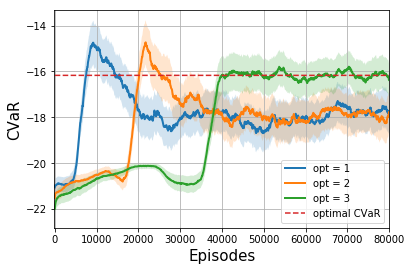

In [230]:
ax = plt.figure()
for i in [1, 2, 3]:
    ret, count = newRead(name, i, 4)
    mean = mv(np.mean(ret, axis=1), n)
    xaxis = np.arange(0, mean.shape[0]*50, 50)
    std = mv(np.std(ret, axis=1)/np.sqrt(trial), n)
    plt.plot(xaxis, mean, label='opt = %d'%(i), linewidth=2)
    plt.fill_between(xaxis, mean-0.25*std, mean+0.25*std, alpha=0.2)

plt.plot(xaxis, -16.17 * np.ones(xaxis.shape), '--', label = 'optimal CVaR')
#plt.ylim([-28, -10]);
plt.xlim([-100, 80000]);
plt.xlabel('Episodes', fontsize = 15)
plt.ylabel('CVaR', fontsize = 15)
plt.legend()
plt.grid()

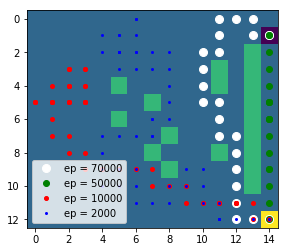

In [218]:
name = '../results/Nav2DSmall/opt_%d_trail_%d_episode_%d.p'
draw(name, world, 0.25, opt=1, trial=2, episodes=[70000, 50000, 10000, 2000])

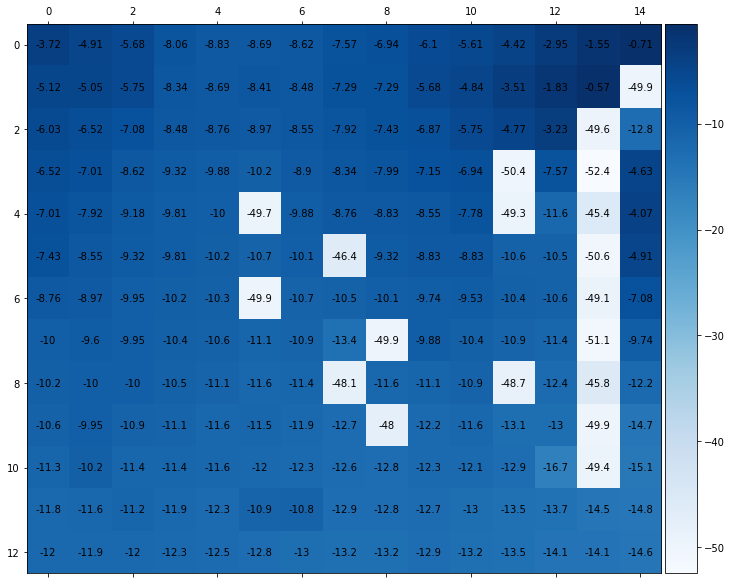

In [113]:
mat = np.zeros((world.maxX, world.maxY))
for x in range(world.maxX):
    for y in range(world.maxY):
        mat[x, y] = np.max(CVaR_policy(p['p'], x * world.maxY + y, 0.25, Vmin=Vmin, Vmax=Vmax))
plt.figure(figsize = (12, 14))
ax = plt.gca()
im = ax.matshow(mat.T, cmap=plt.cm.Blues)

for i in range(world.maxX):
    for j in range(world.maxY):
        c = mat[i,j]
        ax.text(i, j, '%.3g'%(c), va='center', ha='center')
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

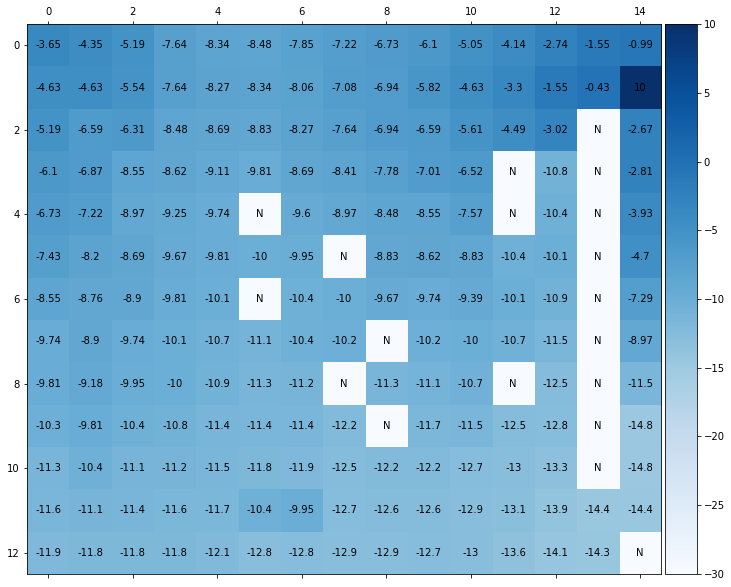

In [114]:

mat = np.zeros((world.maxX, world.maxY))
action = np.zeros((world.maxX, world.maxY))
space = ["UP", "RI", "DO", "LE"]
for x in range(world.maxX):
    for y in range(world.maxY):
        mat[x, y] = np.max(CVaRopt(p['p'], p['counts'],\
                    x * world.maxY + y, 0.25, c=opt, N=20, Vmin=Vmin, Vmax=Vmax))
        action[x, y] = np.argmax(CVaRopt(p['p'], p['counts'], x * world.maxY + y, 0.25, c=opt))
        if world.obstacles[x, y] > 0:
            mat[x, y] = -30
plt.figure(figsize = (12, 14))
ax = plt.gca()
im = ax.matshow(mat.T, cmap=plt.cm.Blues)

for i in range(world.maxX):
    for j in range(world.maxY):
        if world.obstacles[i, j] > 0:
            c = 'N'
            ax.text(i, j, c, va='center', ha='center')
        else:
            c = mat[i,j]
            ax.text(i, j, '%.3g'%(c), va='center', ha='center')
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

In [115]:
x = 10; y = 7
print(np.max(CVaRopt(p['p'], p['counts'], x * world.maxY + y, 0.25, c=opt, N=100000)))
print(world.obstacles[x, y])

28.473603999999998
0.0


39.706320000000005
[39.32 39.43 38.   37.01]
[38.22 39.65 38.   36.68]
[1991. 9401. 1805. 1457.]


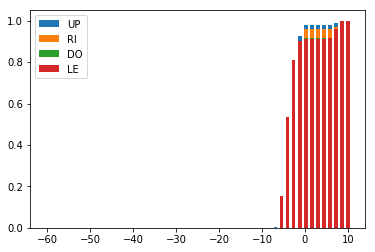

In [104]:
nAtoms=51; nA=4
x=12; y =0
idx = x * world.maxY + y
print(np.max(CVaRopt(p['p'], p['counts'], x * world.maxY + y, 0.25, c=opt, N=100000)))
plt.bar(np.arange(51) * (Vmax - Vmin)/(nAtoms-1) + Vmin, np.cumsum(p['p'][idx, 0, :]), label = space[0])
plt.bar(np.arange(51) * (Vmax - Vmin)/(nAtoms-1) + Vmin, np.cumsum(p['p'][idx, 1, :]), label = space[1])
plt.bar(np.arange(51) * (Vmax - Vmin)/(nAtoms-1) + Vmin, np.cumsum(p['p'][idx, 2, :]), label = space[2])
plt.bar(np.arange(51) * (Vmax - Vmin)/(nAtoms-1) + Vmin, np.cumsum(p['p'][idx, 3, :]), label = space[3])
plt.legend()
print(CVaRopt(p['p'], p['counts'], idx, 0.25, c=opt))
print(CVaR_policy(p['p'],  idx, 0.25))
print(p['counts'][idx, :])

Trainign more

In [661]:
opt = 50; c = 0.1
name = 'Navres/opt_c_%d_load_trail_0_episode_193000.p'%(opt)
p = pickle.load(open(name, 'rb'))
counts = p['counts'].sum(axis = 1)
limit = (opt/c)**2
counts[counts > limit] = limit

In [662]:
mean.shape

(400,)

0.0


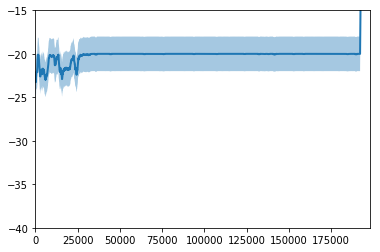

In [663]:
n=20
ret = p['returns']
mean = mv(np.mean(ret, axis=1), n)
xaxis = np.arange(0, mean.shape[0]*50, 50)
std = mv(np.std(ret, axis=0), n)
plt.plot(xaxis, mean, label='opt = %d'%(opt), linewidth=2)
plt.fill_between(xaxis, mean-0.5*std, mean+0.5*std, alpha=0.4)
plt.ylim([-40, -15]);
plt.xlim([-100, 198000]);
print(np.max(ret))

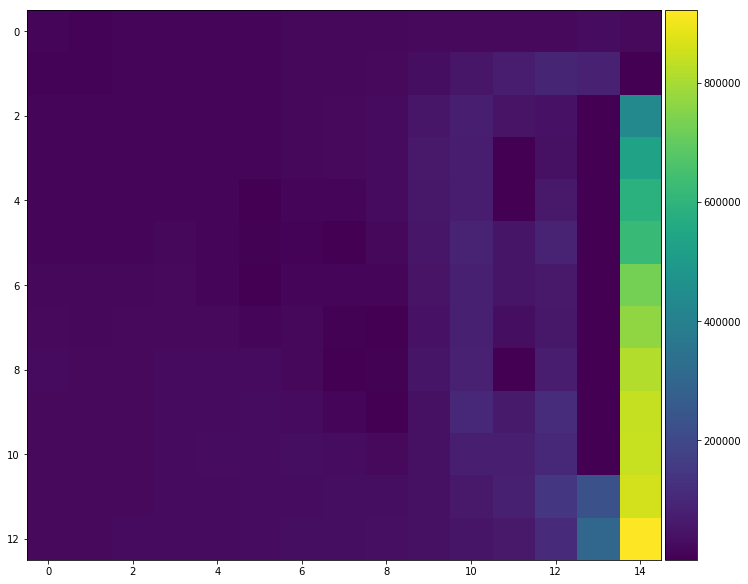

In [116]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

wolrd = Nav2D(random=False)
mat = np.zeros((world.maxX, world.maxY))
for x in range(world.maxX):
    for y in range(world.maxY):
        mat[x, y] = counts[x * world.maxY + y]
plt.figure(figsize = (12, 14))
ax = plt.gca()
im = ax.imshow(mat.T)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

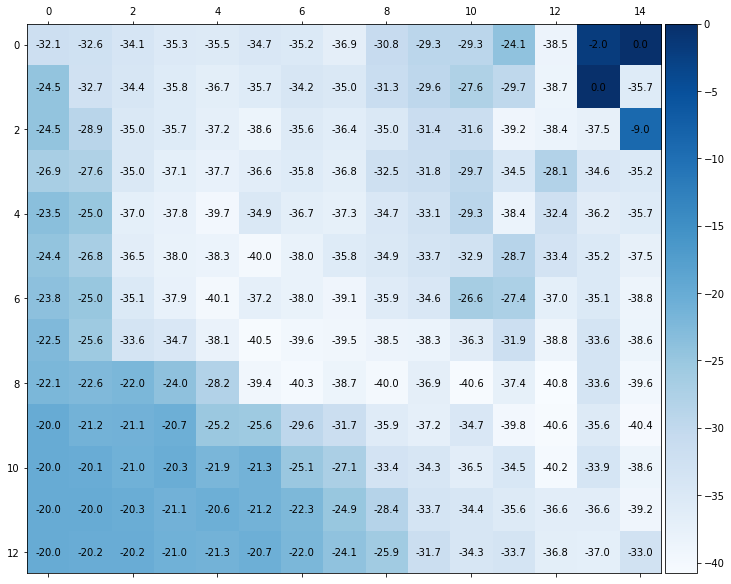

In [19]:
mat = np.zeros((world.maxX, world.maxY))
for x in range(world.maxX):
    for y in range(world.maxY):
        mat[x, y] = np.max(CVaR_policy(p['p'], x * world.maxY + y, 0.25))
plt.figure(figsize = (12, 14))
ax = plt.gca()
im = ax.matshow(mat.T, cmap=plt.cm.Blues)

for i in range(world.maxX):
    for j in range(world.maxY):
        c = mat[i,j]
        ax.text(i, j, str(c), va='center', ha='center')
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

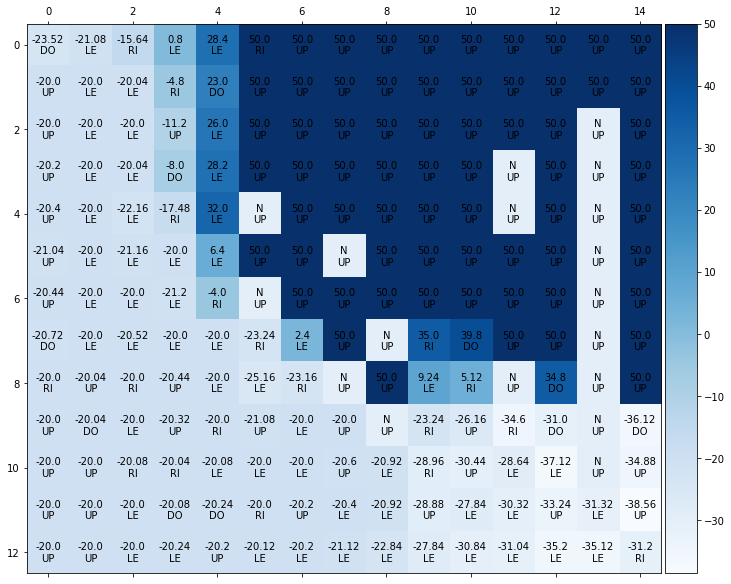

In [20]:
mat = np.zeros((world.maxX, world.maxY))
action = np.zeros((world.maxX, world.maxY))
space = ["UP", "RI", "DO", "LE"]
for x in range(world.maxX):
    for y in range(world.maxY):
        mat[x, y] = np.max(CVaRopt(p['p'], p['counts'], x * world.maxY + y, 0.25, c=opt))
        action[x, y] = np.argmax(CVaRopt(p['p'], p['counts'], x * world.maxY + y, 0.25, c=opt))
        if world.obstacles[x, y] > 0:
            mat[x, y] = -30
plt.figure(figsize = (12, 14))
ax = plt.gca()
im = ax.matshow(mat.T, cmap=plt.cm.Blues)

for i in range(world.maxX):
    for j in range(world.maxY):
        if world.obstacles[i, j] > 0:
            c = 'N'
        else:
            c = mat[i,j]
        ax.text(i, j, str(c) +'\n'+str(space[int(action[i, j])]), va='center', ha='center')
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

14 12 [21.5  21.39 22.16 22.49]
13 12 [22.16 21.61 23.04 23.04]
13 11 [ 22.16  21.94 -21.29  23.59]
12 11 [23.37 22.49 23.7  23.59]
12 10 [ 23.92 -20.3  -20.85  25.13]
11 10 [23.81 23.81 26.01 25.9 ]
11 9 [ 24.91  24.25 -20.85  26.56]
10 9 [25.46 25.24 27.77 26.23]
10 8 [ 25.9  -20.41  27.99  27.44]
10 7 [26.56 27.55 29.53 28.32]
10 6 [28.43 28.76 31.07 28.76]
10 5 [29.31 29.09 31.73 30.41]
10 4 [ 30.19 -20.74  33.38  31.18]
9 4 [30.74 31.29 32.06 30.74]
9 3 [31.4  33.49 33.16 30.85]
10 3 [ 31.07 -20.63  35.14  32.17]
10 2 [33.16 35.91 35.69 33.27]
11 2 [-20.63  37.56  37.78  34.81]
11 1 [35.36 40.2  36.68 35.69]
12 1 [35.91 41.85 38.   37.23]
13 1 [-20.08  43.94  33.71  39.32]


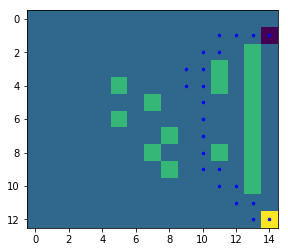

22

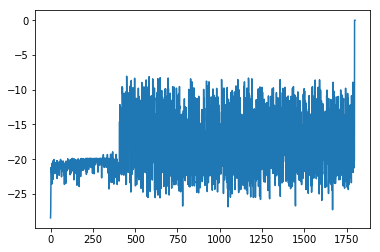

In [42]:
plt.plot(np.mean(p['returns'], axis=1))

In [316]:
p['episode']

2800